# Evaluate model performance

## Prerequisites

In [ ]:
!pip install kaggle

In [1]:
!kaggle competitions download -c titanic

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
import shutil
shutil.unpack_archive('./titanic.zip', './data/')

In [3]:
!pip install ../titanicTraining

Processing c:\users\diego\documents\git\yet-another-titanic-project\titanictraining
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for titanic: filename=titanic-0.1.0-py3-none-any.whl size=18009 sha256=0240f72b520fb42819e941529a6a1630d5cb18e338dcac92ffc19c43828cef68
  Stored in directory: C:\Users\diego\AppData\Local\Temp\pip-ephem-wheel-cache-xud9lxvv\wheels\ce\38\9c\226246269778f6ca770e7504f9e68887a904451270e3e1ff9e
Successfully built titanic
  Attempting uninstall: titanic
    Found existing installation: titanic 0.0.9
    Uninstalling titanic-0.0.9:
      Successfully uninstalled tita

## Data

In [7]:
import pandas as pd

data = pd.read_csv('./data/train.csv')
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Kfold Cross Validation

In [61]:
from pipe import TitanicDataset, FeatureEnricher, DataCleaning, Trainer
import os

class ValidationPipe:
    def __init__(self, train: pd.DataFrame, test: pd.DataFrame) -> None:
        self.train = train
        self.test = test 

        self.train_path = './data/temp_train.csv'
        self.test_path = './data/temp_test.csv'
        self.train.to_csv(self.train_path, index=False)
        self.test.to_csv(self.test_path, index=False)
        self.dataset = TitanicDataset(train_path=self.train_path, test_path=self.test_path)
        self.train = self.dataset.train_data
        self.test = self.dataset.test_data

        self.cleaning = DataCleaning()
        self.train = self.cleaning.fit_transform(self.train)
        self.test = self.cleaning.transform(self.test)
        self.enricher = FeatureEnricher()
        self.train = self.enricher.fit_transform(self.train)
        self.test = self.enricher.transform(self.test)
        self.trainer = Trainer(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='sqrt',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
        self.trainer.fit(self.train.iloc[:, 1:], self.train.iloc[:, 0])
        self.close()
    def close(self):
        os.remove(self.train_path)
        os.remove(self.test_path)
        

In [68]:
from pipe import TrainModelPipeline
from sklearn.model_selection import RepeatedKFold
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

rkf = RepeatedKFold(n_splits=7, n_repeats=2, random_state=1)
metrics = []
for train, test in tqdm(rkf.split(data), total=7*2):
    train_data, test_data_X, test_data_y = data.iloc[train, :], data.iloc[test, :], data.iloc[test, :]['Survived']
    del test_data_X['Survived']
    vp = ValidationPipe(train_data, test_data_X)
    metrics_train = vp.trainer.evaluate(vp.train.iloc[:, 1:], vp.train.iloc[:, 0])
    metrics_test = vp.trainer.evaluate(vp.test, test_data_y)
    metrics.append({"train": metrics_train, "test": metrics_test})
    

100%|██████████| 14/14 [00:54<00:00,  3.90s/it]


## Example Test Metric

In [69]:
print(metrics[0]['test'][1])

              precision    recall  f1-score   support

           0       0.80      0.92      0.86        78
           1       0.84      0.64      0.73        50

    accuracy                           0.81       128
   macro avg       0.82      0.78      0.79       128
weighted avg       0.82      0.81      0.81       128



In [73]:
metrics[0]['test'][0]

{'0': {'precision': 0.8,
  'recall': 0.9230769230769231,
  'f1-score': 0.8571428571428571,
  'support': 78},
 '1': {'precision': 0.8421052631578947,
  'recall': 0.64,
  'f1-score': 0.7272727272727272,
  'support': 50},
 'accuracy': 0.8125,
 'macro avg': {'precision': 0.8210526315789474,
  'recall': 0.7815384615384615,
  'f1-score': 0.7922077922077921,
  'support': 128},
 'weighted avg': {'precision': 0.8164473684210527,
  'recall': 0.8125,
  'f1-score': 0.8064123376623376,
  'support': 128}}

### Train metrics

In [75]:
def get_metrics(metrics, key='train'):
    acc = [m[key][0]['accuracy'] for m in metrics]
    true_f1 = [m[key][0]['1']['f1-score'] for m in metrics]
    false_f1 = [m[key][0]['0']['f1-score'] for m in metrics]
    w_f1 = [m[key][0]['weighted avg']['f1-score'] for m in metrics]
    return acc, true_f1, false_f1, w_f1

In [77]:
train_acc, train_true_f1, train_false_f1, train_w_f1 = get_metrics(metrics, key='train')

In [85]:
import numpy as np
print(f'Mean accuracy: {np.mean(train_acc):.2f}. STD accuracy: {np.std(train_acc):.2f}')
print(f'Mean f1 true labels: {np.mean(train_true_f1):.2f}. STD f1 true labels: {np.std(train_true_f1):.2f}')
print(f'Mean f1 false labels: {np.mean(train_false_f1):.2f}. STD f1 false labels: {np.std(train_false_f1):.2f}')
print(f'Mean weighted f1: {np.mean(train_w_f1):.2f}. STD weighted f1: {np.std(train_w_f1):.2f}')

Mean accuracy: 0.92. STD accuracy: 0.01
Mean f1 true labels: 0.89. STD f1 true labels: 0.01
Mean f1 false labels: 0.93. STD f1 false labels: 0.00
Mean weighted f1: 0.92. STD weighted f1: 0.01


### Test metrics

In [86]:
test_acc, test_true_f1, test_false_f1, test_w_f1 = get_metrics(metrics, key='test')

In [87]:
import numpy as np
print(f'Mean accuracy: {np.mean(test_acc):.2f}. STD accuracy: {np.std(test_acc):.2f}')
print(f'Mean f1 true labels: {np.mean(test_true_f1):.2f}. STD f1 true labels: {np.std(test_true_f1):.2f}')
print(f'Mean f1 false labels: {np.mean(test_false_f1):.2f}. STD f1 false labels: {np.std(test_false_f1):.2f}')
print(f'Mean weighted f1: {np.mean(test_w_f1):.2f}. STD weighted f1: {np.std(test_w_f1):.2f}')

Mean accuracy: 0.83. STD accuracy: 0.03
Mean f1 true labels: 0.76. STD f1 true labels: 0.04
Mean f1 false labels: 0.87. STD f1 false labels: 0.03
Mean weighted f1: 0.83. STD weighted f1: 0.03


## Feature importance of our model

In [88]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
vp = ValidationPipe(train, test)

In [113]:
%%time
importances = vp.trainer.model.feature_importances_
std = np.std([tree.feature_importances_ for tree in vp.trainer.model.estimators_], axis=0)

CPU times: total: 62.5 ms
Wall time: 166 ms


#### MDI

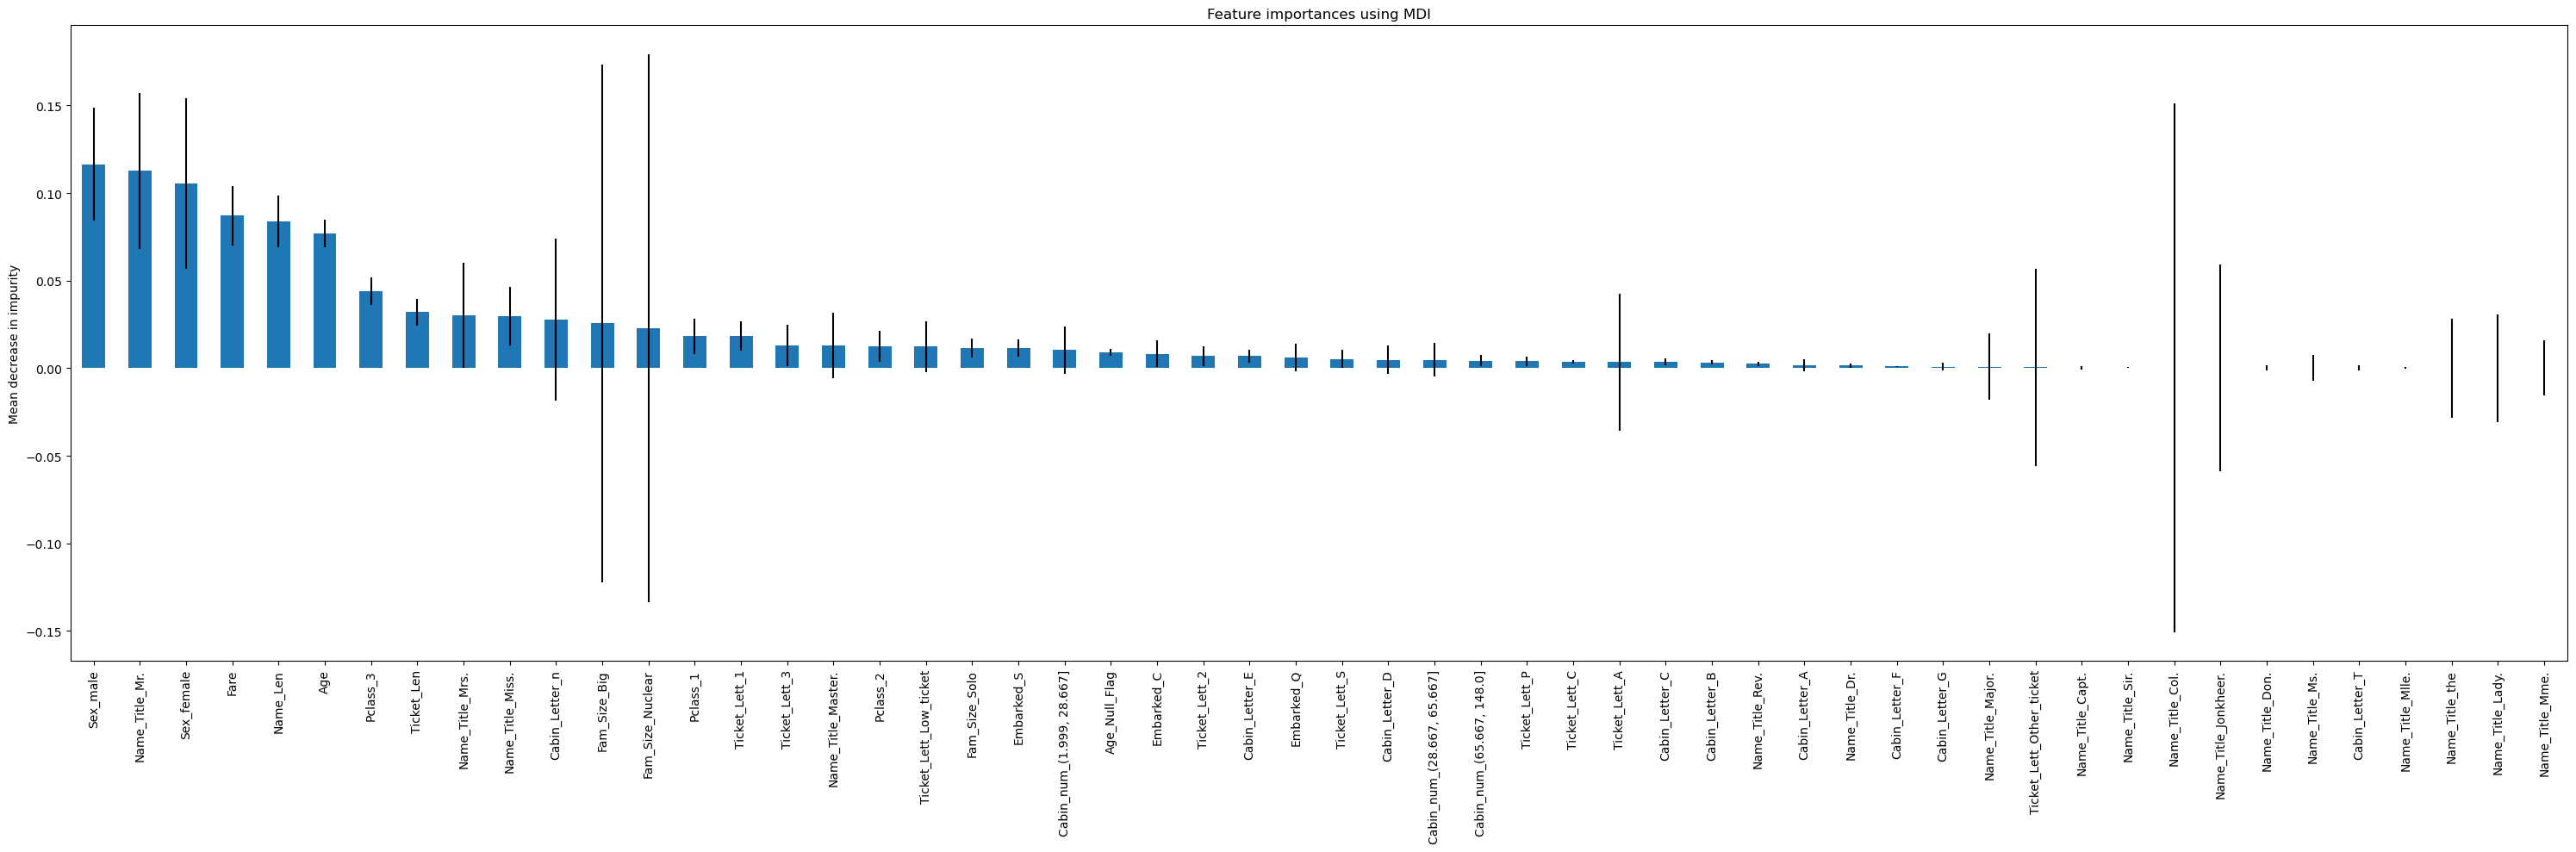

In [114]:
import pandas as pd
import matplotlib.pyplot as plt

forest_importances = pd.Series(importances, index=vp.train.columns.tolist()[1:]).sort_values(ascending = False)

fig, ax = plt.subplots(figsize=(30, 10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Permutation importance

In [115]:
vp = ValidationPipe(train, test)

In [116]:
%%time
from sklearn.inspection import permutation_importance

result = permutation_importance(
    vp.trainer.model, vp.train.iloc[:, 1:], vp.train.iloc[:, 0], n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=vp.train.columns.tolist()[1:]).sort_values(ascending = False)

CPU times: total: 9.44 s
Wall time: 1min 46s


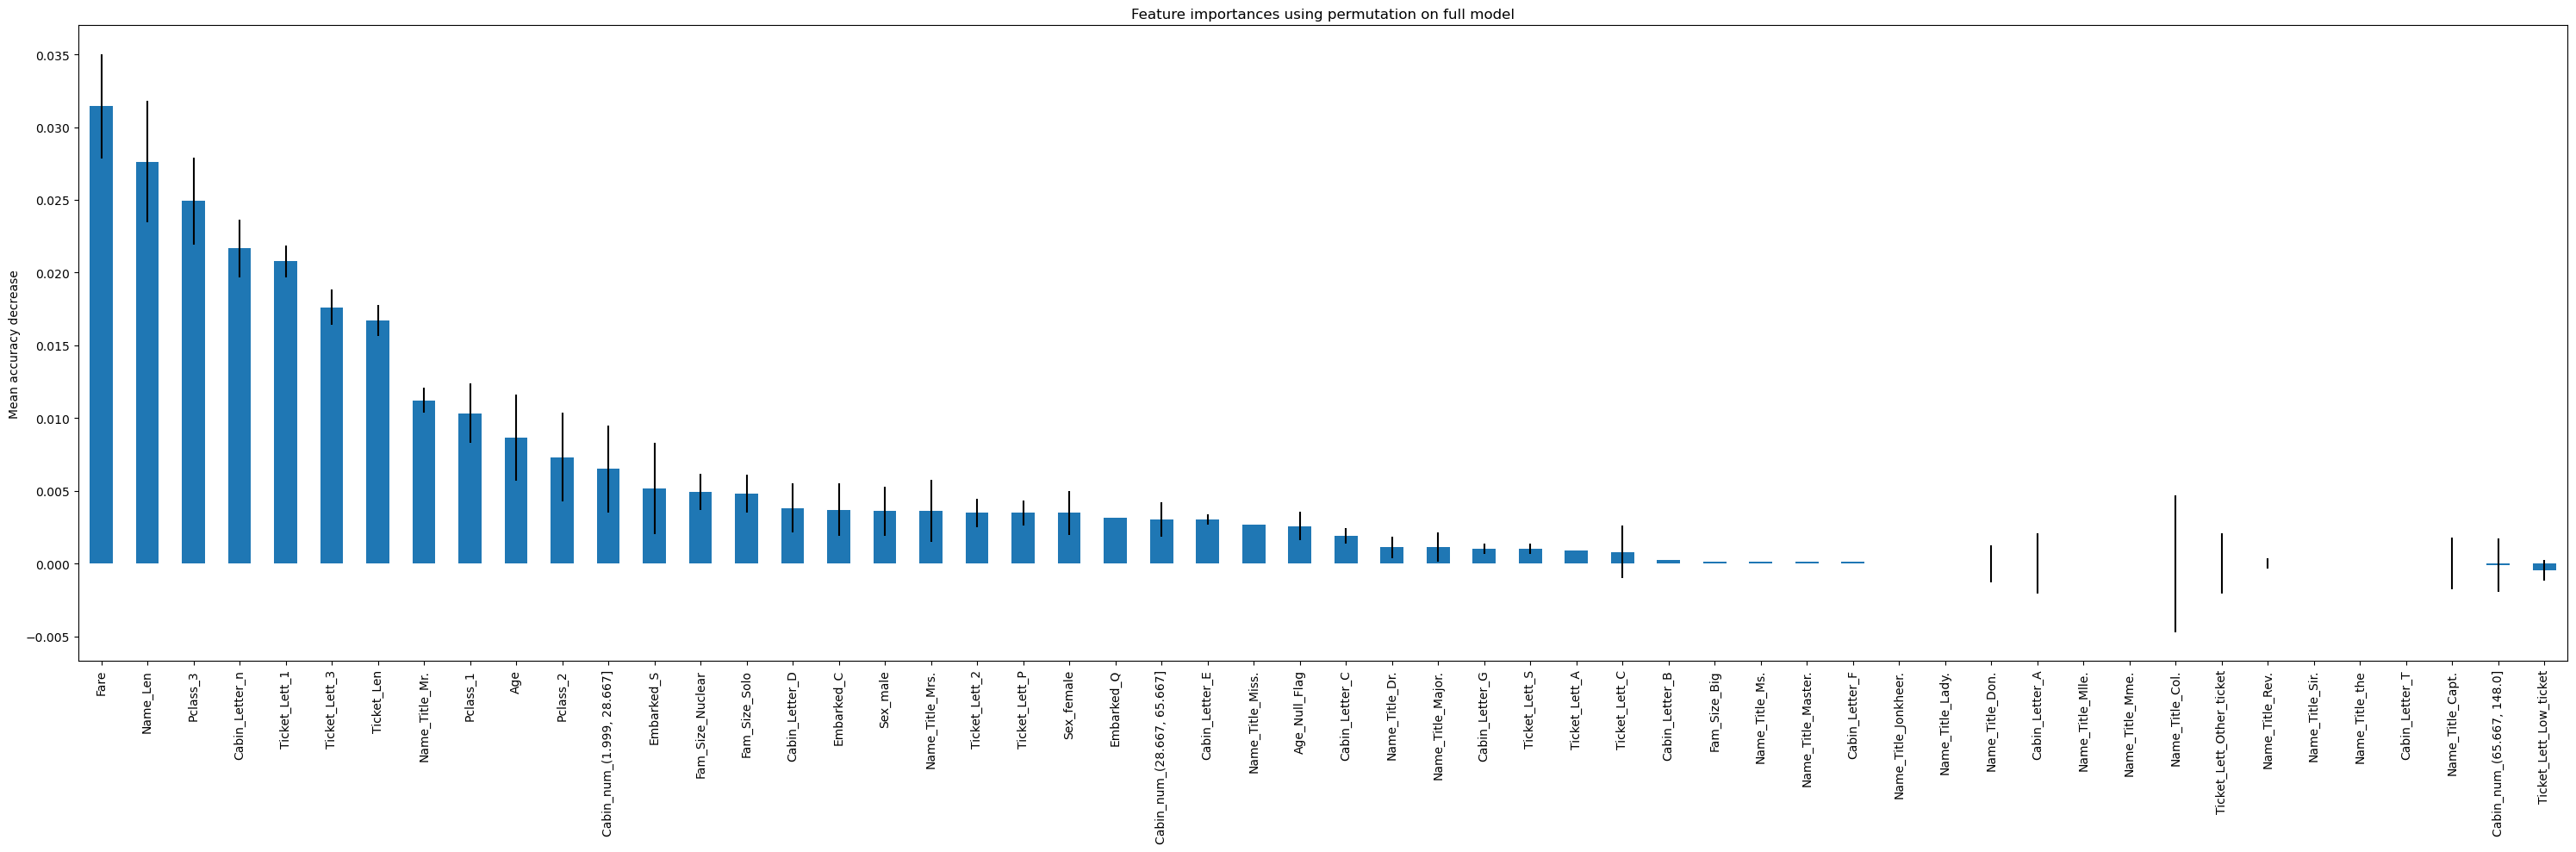

In [117]:
fig, ax = plt.subplots(figsize=(30, 10))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()